In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow.keras import layers,models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
from sklearn.metrics import classification_report,accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [4]:
scaler = StandardScaler()
rfc = RandomForestClassifier(n_estimators=1000,max_depth = 2,random_state=42,)
svc = SVC(kernel = 'linear')

In [7]:
data  = pd.read_csv('/content/sample_data/copd.csv')

In [8]:
data.head()

,Unnamed: 0,ID,AGE,PackHistory,COPDSEVERITY,MWT1,MWT2,MWT1Best,FEV1,FEV1PRED,...,SGRQ,AGEquartiles,copd,gender,smoking,Diabetes,muscular,hypertension,AtrialFib,IHD
0,1,58,77,60.0,SEVERE,120.0,120.0,120.0,1.21,36.0,...,69.55,4,3,1,2,1,0,0,1,0
1,2,57,79,50.0,MODERATE,165.0,176.0,176.0,1.09,56.0,...,44.24,4,2,0,2,1,0,0,1,1
2,3,62,80,11.0,MODERATE,201.0,180.0,201.0,1.52,68.0,...,44.09,4,2,0,2,1,0,0,1,0
3,4,145,56,60.0,VERY SEVERE,210.0,210.0,210.0,0.47,14.0,...,62.04,1,4,1,2,0,0,1,1,0
4,5,136,65,68.0,SEVERE,204.0,210.0,210.0,1.07,42.0,...,75.56,1,3,1,2,0,1,1,0,0


In [9]:
data.columns

Index(['Unnamed: 0', 'ID', 'AGE', 'PackHistory', 'COPDSEVERITY', 'MWT1',
       'MWT2', 'MWT1Best', 'FEV1', 'FEV1PRED', 'FVC', 'FVCPRED', 'CAT', 'HAD',
       'SGRQ', 'AGEquartiles', 'copd', 'gender', 'smoking', 'Diabetes',
       'muscular', 'hypertension', 'AtrialFib', 'IHD'],
      dtype='object')

In [10]:
print(data['copd'].value_counts())
print(data['COPDSEVERITY'].value_counts())

2    43
3    27
1    23
4     8
Name: copd, dtype: int64
MODERATE       43
SEVERE         27
MILD           23
VERY SEVERE     8
Name: COPDSEVERITY, dtype: int64


Dropping the unwanted columns to make the results more accurate

In [11]:
columns = ['Unnamed: 0','ID','COPDSEVERITY','MWT1','MWT2']
data.drop(columns=columns, axis=1,inplace=True)

In [12]:
data.shape

(101, 19)

In [13]:
data.head()

,AGE,PackHistory,MWT1Best,FEV1,FEV1PRED,FVC,FVCPRED,CAT,HAD,SGRQ,AGEquartiles,copd,gender,smoking,Diabetes,muscular,hypertension,AtrialFib,IHD
0,77,60.0,120.0,1.21,36.0,2.40,98,25,8.0,69.55,4,3,1,2,1,0,0,1,0
1,79,50.0,176.0,1.09,56.0,1.64,65,12,21.0,44.24,4,2,0,2,1,0,0,1,1
2,80,11.0,201.0,1.52,68.0,2.30,86,22,18.0,44.09,4,2,0,2,1,0,0,1,0
3,56,60.0,210.0,0.47,14.0,1.14,27,28,26.0,62.04,1,4,1,2,0,0,1,1,0
4,65,68.0,210.0,1.07,42.0,2.91,98,32,18.0,75.56,1,3,1,2,0,1,1,0,0


Exploratory Data Anaylsis

<Axes: >

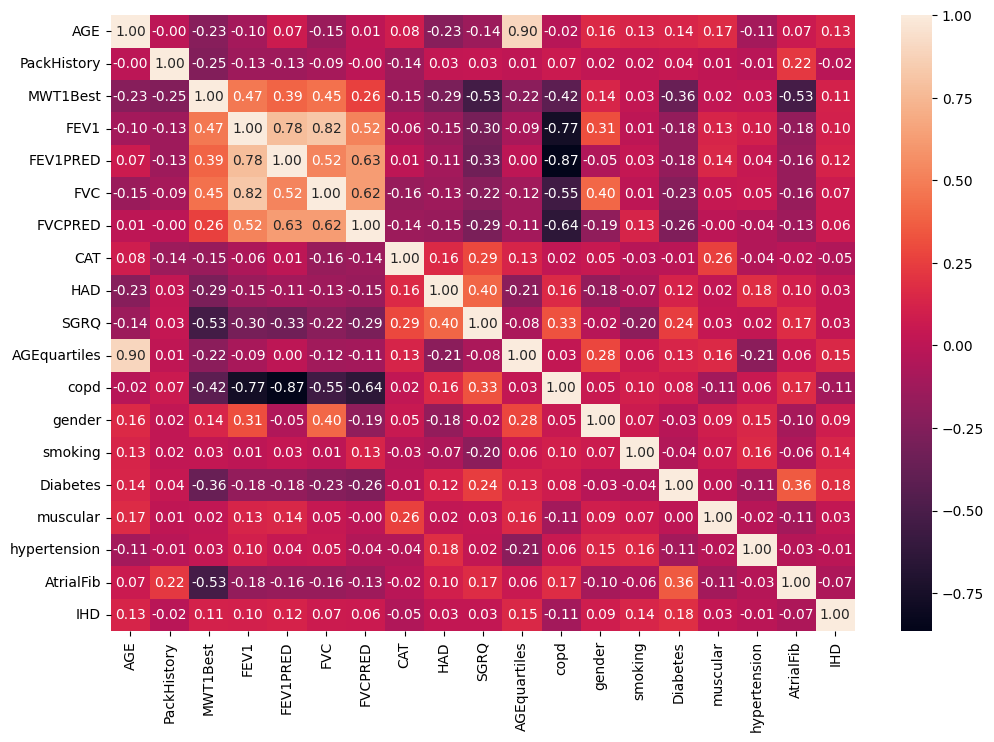

In [14]:
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(),annot=True,cmap='rocket',fmt='.2f')

Age Distributions

In [15]:
age = pd.DataFrame(data['AGE'].value_counts(bins=3)).reset_index()
age.columns = ['Range','Age']
age['Range'].astype(str)
for i,col in enumerate(age):
  for row in range(age.shape[0]):
    age[col][row] = age[col].astype('str')[row][1:-1]
  break
age['Range'][2]  = '43.9551, 58.667'

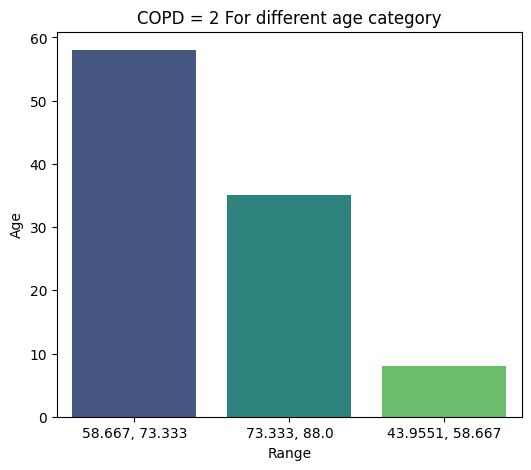

In [16]:
plt.figure(figsize=(6,5))
sns.barplot(data = age , x='Range',y='Age',palette = 'viridis')
plt.title('COPD = 2 For different age category')
plt.xticks(rotation=0)
plt.show()

COPD - Severity levels
(VERY SEVERE - 4
SEVERE      - 3
MODERATE    - 2
MILD        - 1)

In [17]:
data['copd'].value_counts()

2    43
3    27
1    23
4     8
Name: copd, dtype: int64

In [18]:
df = data.groupby([pd.cut(data['AGE'], bins=3),'copd']).size().unstack().reset_index().rename(columns={'index': 'AGE'})

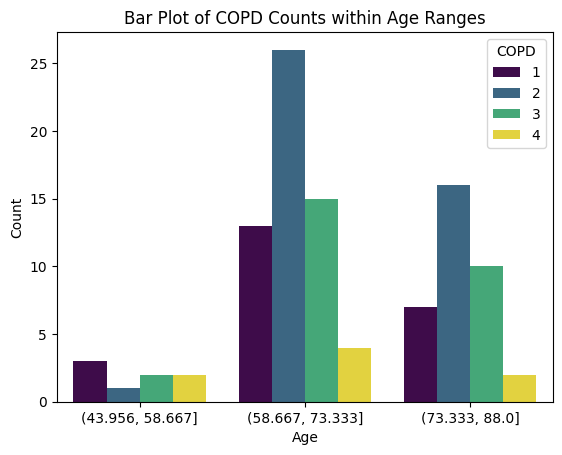

In [19]:
df_melted = pd.melt(df, id_vars=['AGE'], var_name='COPD', value_name='Count')
sns.barplot(x='AGE', y='Count', hue='COPD', data=df_melted, palette='viridis')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Bar Plot of COPD Counts within Age Ranges')
plt.legend(title='COPD')
plt.show()

Smoking Patterns

How does PackHistory vary between smokers and non-smokers?

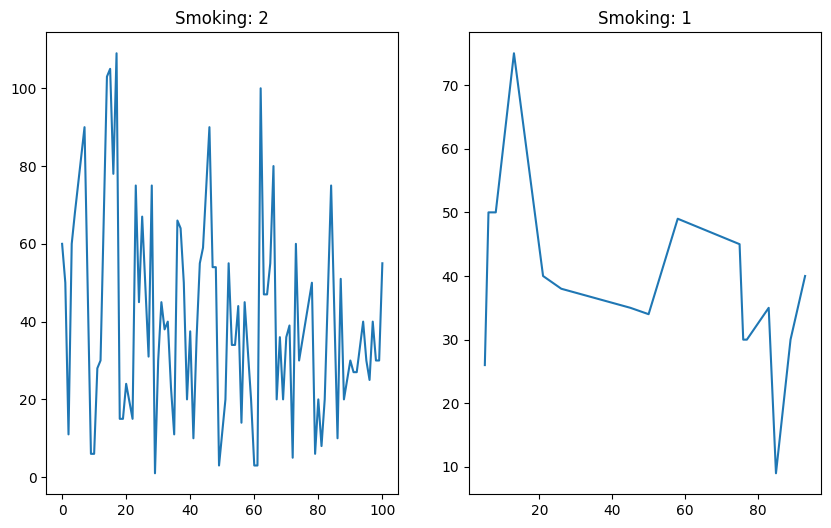

In [20]:
fig,ax = plt.subplots(1,2,figsize = (10,6))
for count,i in enumerate(data['smoking'].unique()):
    ax[count].set_title(f'Smoking: {i}')
    ax[count].plot(data[data['smoking']==i]['PackHistory'])

Physical Performance

In [21]:
columns = ['AGE','MWT1Best']
df = pd.DataFrame({col : data[col] for col in columns})
df['Age Range'] = pd.cut(df['AGE'],bins=3)
df['MWT1Best'] = pd.to_numeric(df['MWT1Best'], errors='coerce')
df.groupby('Age Range')['MWT1Best'].mean().reset_index()
df['Age Range']=df['Age Range'].astype('str')
for i,col in enumerate(df['Age Range']):
    df['Age Range'][i] = col[1:-1]

<Axes: xlabel='Age Range', ylabel='MWT1Best'>

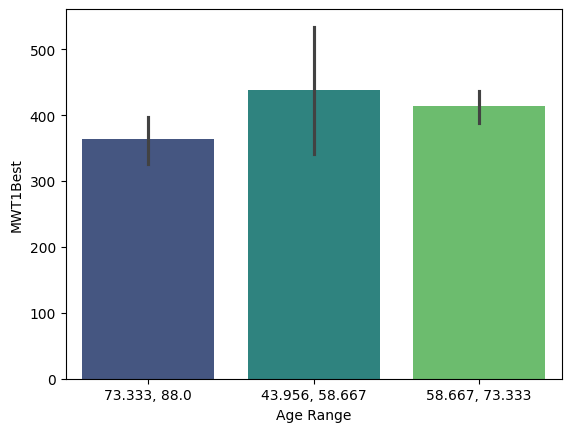

In [22]:
sns.barplot(data = df,x='Age Range',y='MWT1Best',palette='viridis')

Lung Function Analysis                                                  
Are there relationships between lung metrics and diabetes?

In [23]:
df = data[['FVC','Diabetes']]
df['FVC Range'] = pd.cut(df.FVC,bins=3)
df = df.groupby(['FVC Range','Diabetes']).size().unstack(fill_value=0).reset_index()
df

Diabetes,FVC Range,0,1
0,"(1.136, 2.55]",26,16
1,"(2.55, 3.96]",38,3
2,"(3.96, 5.37]",16,2


<Axes: xlabel='FVC Range', ylabel='Count'>

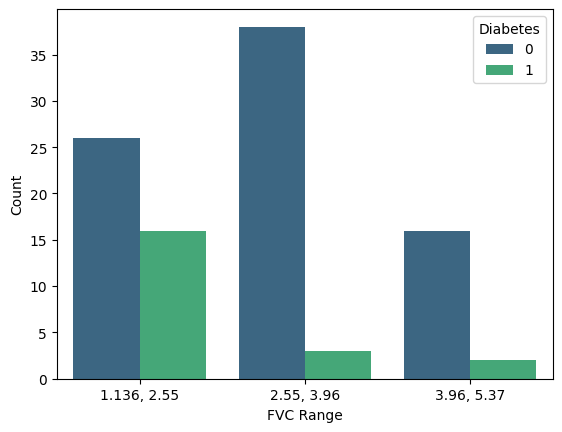

In [24]:
df_melted = pd.melt(df, id_vars=['FVC Range'], var_name='Diabetes', value_name='Count')
df_melted['FVC Range'] = df_melted['FVC Range'].astype(str)
for i,row in enumerate(df_melted['FVC Range']):
  df_melted['FVC Range'][i] = row[1:-1]
sns.barplot(data=df_melted,x='FVC Range',y='Count',hue='Diabetes',palette='viridis')

Health Scores:

What is the distribution of CAT, HAD, and SGRQ scores?

<Axes: ylabel='CAT'>

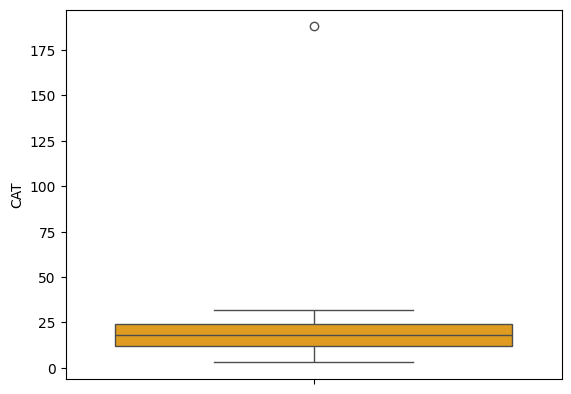

In [25]:
#CAT Scores
sns.boxplot(data['CAT'],saturation=0.75,color='orange')

In [26]:
data['CAT'].describe()

count    101.000000
mean      19.336634
std       18.674730
min        3.000000
25%       12.000000
50%       18.000000
75%       24.000000
max      188.000000
Name: CAT, dtype: float64

<Axes: xlabel='CAT', ylabel='Density'>

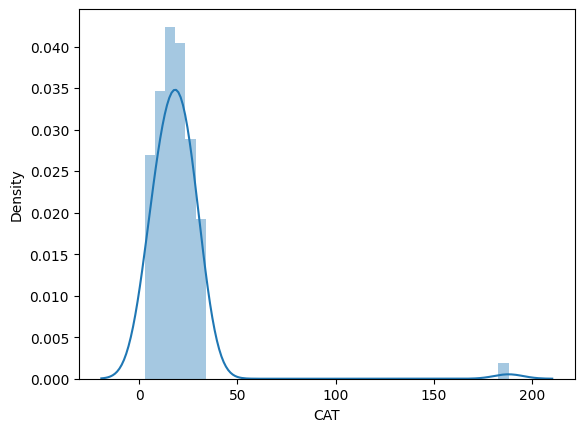

In [27]:
sns.distplot(data['CAT'])

In [28]:
data['CAT'].value_counts(bins=2)

(2.814, 95.5]    100
(95.5, 188.0]      1
Name: CAT, dtype: int64

In [29]:
data['gender'].unique()

array([1, 0])

In [30]:
data['gender'].value_counts().max()

65

In [31]:
data.loc[data['gender'] == 10, 'gender'] = 1
data.loc[data['gender'] == 30, 'gender'] = 1

In [32]:
df = data[['CAT','gender']]
df['CAT Range'] = pd.cut(data['CAT'],bins=2)
res = df.groupby(['CAT Range','gender']).size().unstack().reset_index()
res

gender,CAT Range,0,1
0,"(2.815, 95.5]",36,64
1,"(95.5, 188.0]",0,1


<Axes: xlabel='CAT Range', ylabel='Count'>

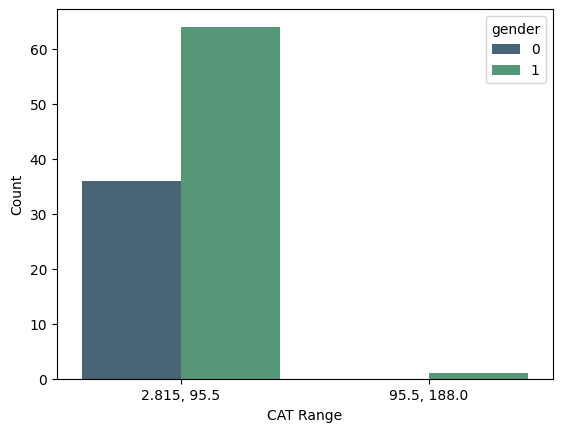

In [33]:
df_melted = pd.melt(res,id_vars= 'CAT Range',var_name = 'gender',value_name='Count')
df_melted['CAT Range'] = df_melted['CAT Range'].astype('str')
for i,row in enumerate(df_melted['CAT Range']):
 df_melted['CAT Range'][i] = row[1:-1]
sns.barplot(data = df_melted,x='CAT Range',y='Count',hue='gender',palette='viridis',saturation=0.5)

In [34]:
data['HAD'].describe()

count    101.000000
mean      11.180198
std        8.588807
min        0.000000
25%        6.000000
50%       10.000000
75%       15.000000
max       56.200000
Name: HAD, dtype: float64

<Axes: ylabel='HAD'>

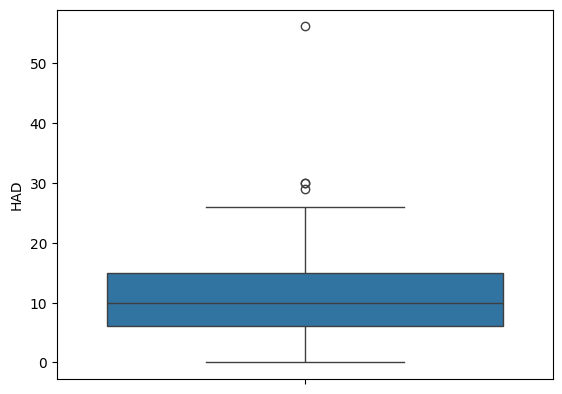

In [35]:
sns.boxplot(data['HAD'])

<Axes: xlabel='HAD', ylabel='Density'>

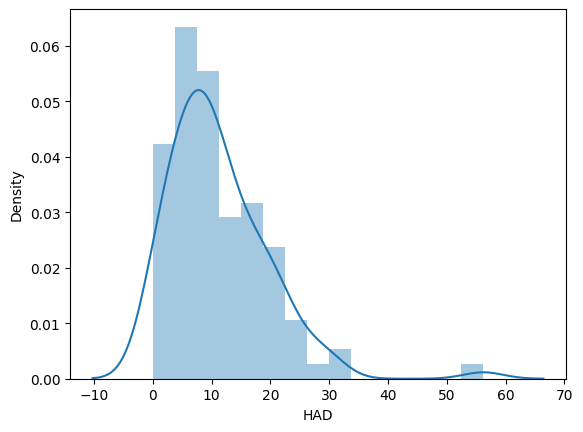

In [36]:
sns.distplot(data['HAD'])

In [37]:
data[data['HAD'] > 50] = data['HAD'].median()

<Axes: ylabel='HAD'>

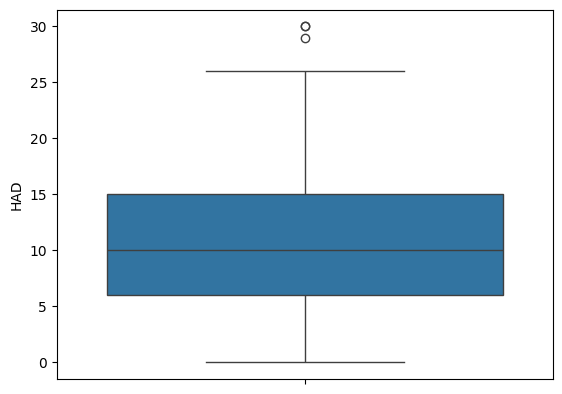

In [38]:
sns.boxplot(data['HAD'])

In [ ]:
data['HAD'].value_counts(bins = 3)

(-0.031, 10.0]    56
(10.0, 20.0]      32
(20.0, 30.0]      13
Name: HAD, dtype: int64

In [ ]:
df = data[['HAD','gender']]
print(df['gender'].unique())
df['HAD Range'] = pd.cut(data['HAD'],bins=3)
res = df.groupby(['HAD Range','gender']).size().unstack().reset_index()
res

[1 0]


gender,HAD Range,0,1
0,"(-0.03, 10.0]",15,40
1,"(10.0, 20.0]",15,17
2,"(20.0, 30.0]",5,7


<Axes: xlabel='HAD Range', ylabel='Counts'>

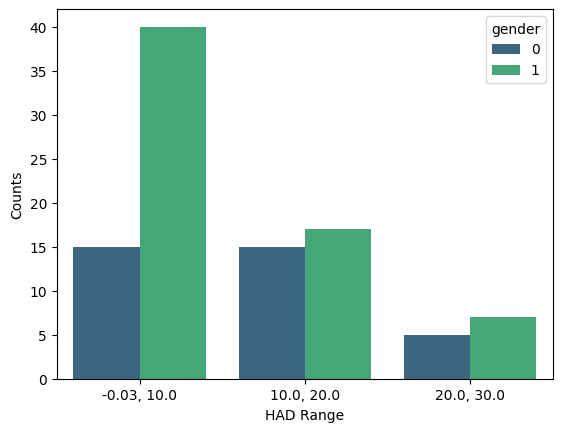

In [ ]:
df_melt = pd.melt(res,id_vars = 'HAD Range',var_name='gender',value_name='Counts')
df_melt['HAD Range'] = df_melt['HAD Range'].astype('str')
for i,row in enumerate(df_melt['HAD Range']):
 df_melt['HAD Range'][i] = row[1:-1]
sns.barplot(data=df_melt,x='HAD Range',y='Counts',hue='gender',palette='viridis')

COPD Analysis:

What is the COPD prevalence, and how does it differ by gender?

In [39]:
data.drop(data[data['copd']==30].index,axis=0,inplace=True)

In [40]:
data.drop(data[data['copd']==10].index,axis=0,inplace=True)

In [41]:
df = data[['gender','copd']]
gender_fem = {}
for x in df[df['gender']==0]['copd']:
  if(x in gender_fem):
    gender_fem[x]+=1
  else:
    gender_fem[x] =1
females_COPD  = df.groupby(['gender','copd']).size().unstack()
females_COPD.reset_index(inplace=True)
females_COPD

copd,gender,1,2,3,4
0,0,7,18,7,3
1,1,15,25,20,5


<Axes: xlabel='gender', ylabel='Count'>

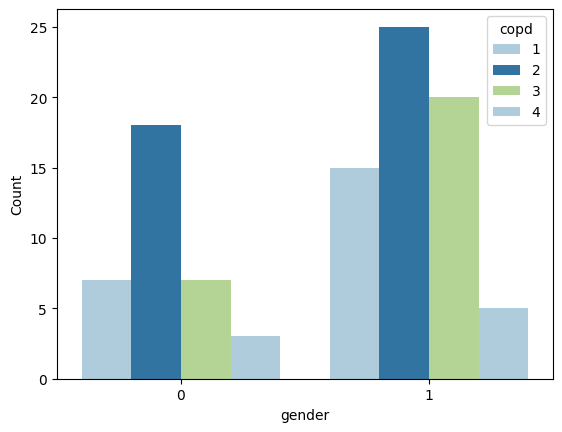

In [42]:
res = females_COPD.melt(id_vars='gender',var_name='copd',value_name='Count')
custom_palette = sns.color_palette("Paired", 3)
sns.barplot(data=res,x='gender',y='Count',hue='copd',palette=custom_palette)

In [43]:
print(females_COPD.columns)


Index(['gender', 1, 2, 3, 4], dtype='object', name='copd')


Finding the null and duplicated values

In [44]:
data.isna().sum()

AGE             0
PackHistory     0
MWT1Best        1
FEV1            0
FEV1PRED        0
FVC             0
FVCPRED         0
CAT             0
HAD             0
SGRQ            0
AGEquartiles    0
copd            0
gender          0
smoking         0
Diabetes        0
muscular        0
hypertension    0
AtrialFib       0
IHD             0
dtype: int64

In [45]:
data.fillna(data.mean(),inplace=True)

In [46]:
data.isna().sum()

AGE             0
PackHistory     0
MWT1Best        0
FEV1            0
FEV1PRED        0
FVC             0
FVCPRED         0
CAT             0
HAD             0
SGRQ            0
AGEquartiles    0
copd            0
gender          0
smoking         0
Diabetes        0
muscular        0
hypertension    0
AtrialFib       0
IHD             0
dtype: int64

In [48]:
data.duplicated().sum()

0

In [49]:
data.describe()

,AGE,PackHistory,MWT1Best,FEV1,FEV1PRED,FVC,FVCPRED,CAT,HAD,SGRQ,AGEquartiles,copd,gender,smoking,Diabetes,muscular,hypertension,AtrialFib,IHD
count,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000
mean,70.150000,39.895000,398.292929,1.59850,58.196800,2.952500,86.14000,19.280000,10.730000,40.567700,2.490000,2.210000,0.650000,1.840000,0.21000,0.190000,0.110000,0.200000,0.090000
std,7.921809,24.602116,106.236372,0.67406,22.150669,0.980889,21.64452,18.760091,7.337265,17.920799,1.105496,0.879566,0.479372,0.368453,0.40936,0.394277,0.314466,0.402015,0.287623
min,44.000000,1.000000,120.000000,0.45000,3.290000,1.140000,27.00000,3.000000,0.000000,8.120000,1.000000,1.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,65.750000,22.250000,303.750000,1.09750,42.000000,2.260000,71.00000,12.000000,6.000000,28.410000,1.750000,2.000000,0.000000,2.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,71.500000,36.000000,419.500000,1.57000,60.000000,2.740000,84.00000,18.000000,9.500000,38.320000,3.000000,2.000000,1.000000,2.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,75.000000,54.000000,462.750000,1.93750,75.000000,3.630000,102.25000,23.250000,15.000000,55.312500,3.000000,3.000000,1.000000,2.000000,0.00000,0.000000,0.000000,0.000000,0.000000
max,88.000000,109.000000,699.000000,3.18000,102.000000,5.370000,132.00000,188.000000,30.000000,77.440000,4.000000,4.000000,1.000000,2.000000,1.00000,1.000000,1.000000,1.000000,1.000000


Prediction of COPD-Severity

In [50]:
#splitting the data
X=data.loc[:,data.columns!='copd']
y=data['copd']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((80, 18), (20, 18), (80,), (20,))

In [51]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [52]:
rfc_model = rfc.fit(X_train,y_train)
svc_model = svc.fit(X_train,y_train)

In [53]:
rfc_pred = rfc_model.predict(X_test)
svc_pred = svc_model.predict(X_test)

In [54]:
print(classification_report(rfc_pred,y_test))
print(classification_report(svc_pred,y_test))

              precision    recall  f1-score   support

           1       0.33      1.00      0.50         1
           2       1.00      0.78      0.88         9
           3       1.00      0.80      0.89        10
           4       0.00      0.00      0.00         0

    accuracy                           0.80        20
   macro avg       0.58      0.64      0.57        20
weighted avg       0.97      0.80      0.86        20

              precision    recall  f1-score   support

           1       0.67      0.50      0.57         4
           2       0.71      0.56      0.63         9
           3       0.62      1.00      0.77         5
           4       1.00      1.00      1.00         2

    accuracy                           0.70        20
   macro avg       0.75      0.76      0.74        20
weighted avg       0.71      0.70      0.69        20



In [55]:
print(f'Accuracy of Random Forest Classifier  : {accuracy_score(rfc_pred,y_test)*100}%')
print(f'Accuracy of Random Forest Classifier  : {accuracy_score(svc_pred,y_test)*100}%')

Accuracy of Random Forest Classifier  : 80.0%
Accuracy of Random Forest Classifier  : 70.0%


Building an ANN

In [56]:
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(18,)),
    layers.Dense(32, activation='sigmoid'),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(4, activation='softmax')
])

In [57]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [58]:
y_train-=1

In [59]:
y_test-=1

In [60]:
history = model.fit(X_train_scaled, y_train,epochs=100,batch_size=32)

Epoch 1/100
3/3 [==============================] - 1s 6ms/step - loss: 1.3324 - accuracy: 0.2375
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 1.3143 - accuracy: 0.2375
Epoch 3/100
3/3 [==============================] - 0s 4ms/step - loss: 1.3005 - accuracy: 0.2375
Epoch 4/100
3/3 [==============================] - 0s 3ms/step - loss: 1.2851 - accuracy: 0.2375
Epoch 5/100
3/3 [==============================] - 0s 4ms/step - loss: 1.2725 - accuracy: 0.2375
Epoch 6/100
3/3 [==============================] - 0s 4ms/step - loss: 1.2604 - accuracy: 0.2375
Epoch 7/100
3/3 [==============================] - 0s 3ms/step - loss: 1.2481 - accuracy: 0.2375
Epoch 8/100
3/3 [==============================] - 0s 3ms/step - loss: 1.2358 - accuracy: 0.2375
Epoch 9/100
3/3 [==============================] - 0s 4ms/step - loss: 1.2236 - accuracy: 0.2375
Epoch 10/100
3/3 [==============================] - 0s 4ms/step - loss: 1.2118 - accuracy: 0.2750
Epoch 11/100
3/3 [===========

In [61]:
acc = history.history['accuracy']
loss = history.history['loss']

In [62]:
print(f'Accuracy of ANN is {round(acc[-1] * 100, 2)}%')
print(f'Loss of ANN is {loss[-1]}')

Accuracy of ANN is 72.5%
Loss of ANN is 0.5447783470153809


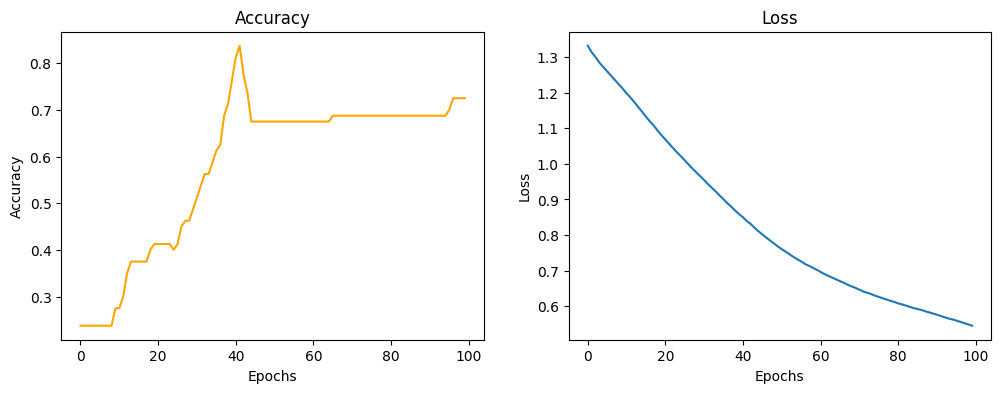

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Plot training accuracy
ax[0].plot(acc,color='orange')
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

# Plot training loss
ax[1].plot(loss)
ax[1].set_title('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')